In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# Basic information about the dataset
train_df.info()

# Basic statistics
train_df.describe()

# Checking for missing values
train_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

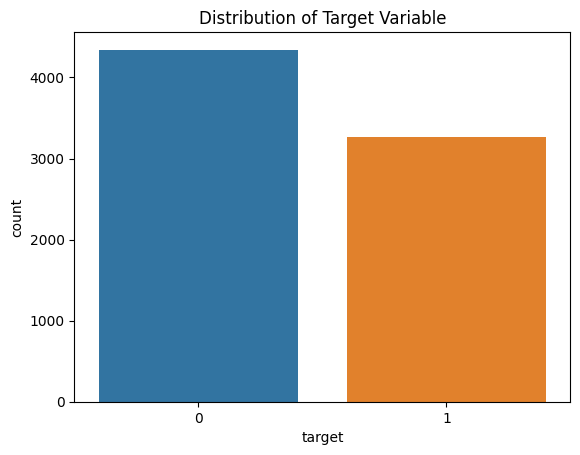

target
0    57.034021
1    42.965979
Name: proportion, dtype: float64


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of target variable
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.show()

# Percentage of each class
print(train_df['target'].value_counts(normalize=True) * 100)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

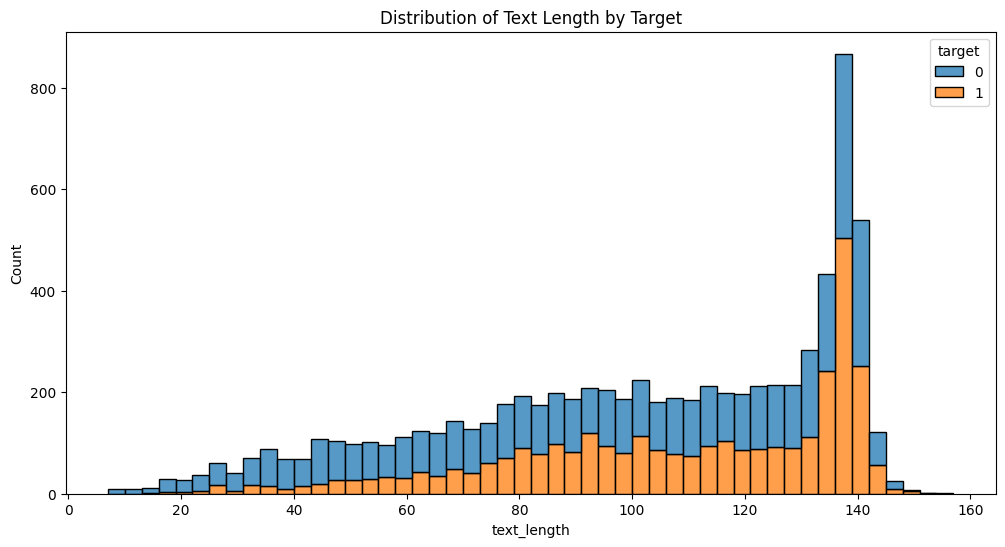

In [6]:
# Adding a column for text length
train_df['text_length'] = train_df['text'].apply(len)

# Plotting the distribution of text length
plt.figure(figsize=(12, 6))
sns.histplot(data=train_df, x='text_length', hue='target', multiple="stack", bins=50)
plt.title('Distribution of Text Length by Target')
plt.show()

In [7]:
import re
import string

def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = text.strip()
    return text

# Apply the preprocessing to the text column
train_df['cleaned_text'] = train_df['text'].apply(preprocess_text)

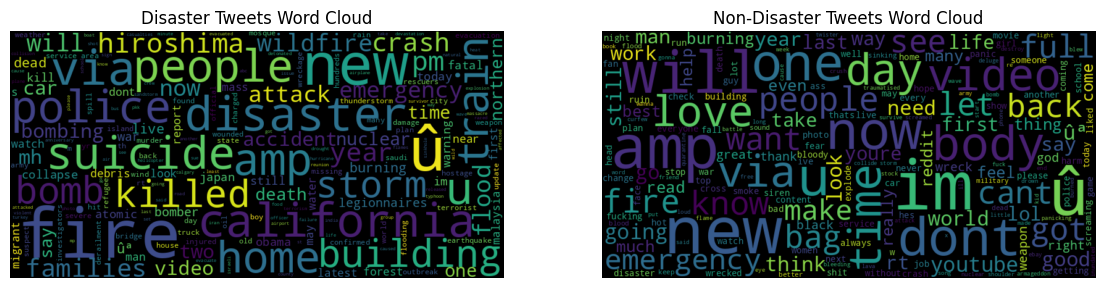

In [8]:
from wordcloud import WordCloud

# Word cloud for disaster tweets
disaster_tweets = ' '.join(train_df[train_df['target'] == 1]['cleaned_text'])
wordcloud_disaster = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(disaster_tweets)

# Word cloud for non-disaster tweets
non_disaster_tweets = ' '.join(train_df[train_df['target'] == 0]['cleaned_text'])
wordcloud_non_disaster = WordCloud(width=800, height=400, max_font_size=110, collocations=False).generate(non_disaster_tweets)

# Plotting the word clouds
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_disaster, interpolation='bilinear')
plt.title('Disaster Tweets Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_non_disaster, interpolation='bilinear')
plt.title('Non-Disaster Tweets Word Cloud')
plt.axis('off')

plt.show()

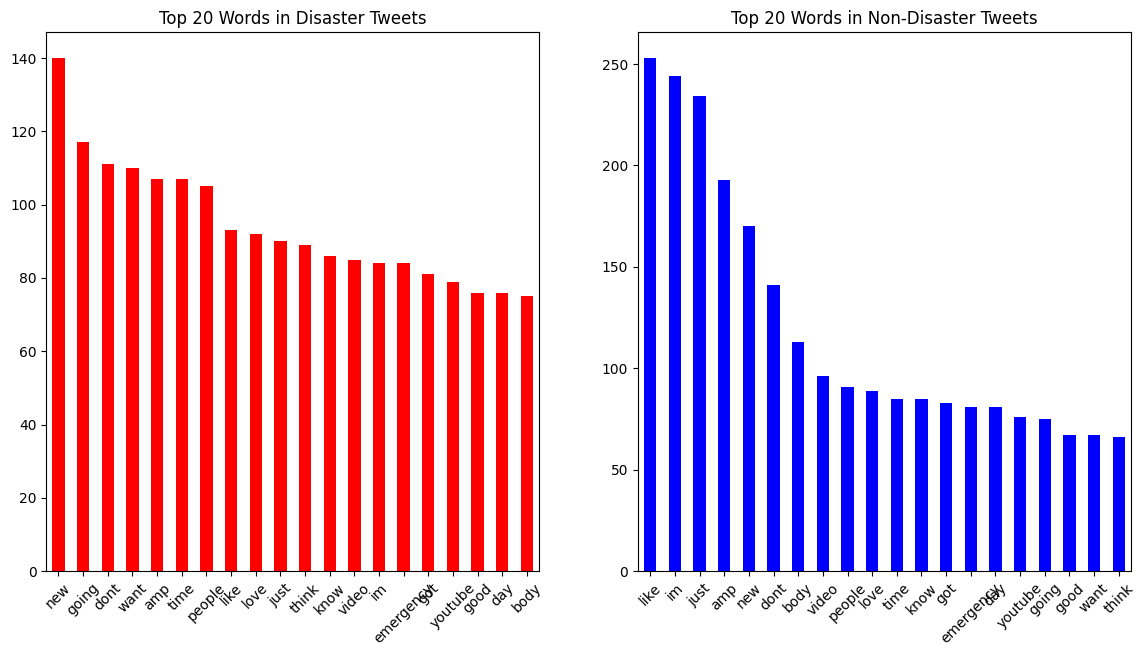

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Vectorizing the text using CountVectorizer
vectorizer = CountVectorizer(stop_words='english', max_features=20)
disaster_vec = vectorizer.fit_transform(train_df[train_df['target'] == 1]['cleaned_text'])
non_disaster_vec = vectorizer.fit_transform(train_df[train_df['target'] == 0]['cleaned_text'])

# Converting to DataFrame
disaster_words = pd.DataFrame(disaster_vec.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)
non_disaster_words = pd.DataFrame(non_disaster_vec.toarray(), columns=vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)

# Plotting the top 20 common words for disaster and non-disaster tweets
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
disaster_words.plot(kind='bar', color='red')
plt.title('Top 20 Words in Disaster Tweets')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
non_disaster_words.plot(kind='bar', color='blue')
plt.title('Top 20 Words in Non-Disaster Tweets')
plt.xticks(rotation=45)

plt.show()

In [11]:
from sklearn.model_selection import train_test_split

# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_df['cleaned_text'], train_df['target'], test_size=0.2, random_state=42)

# Display the shape of the splits
print(f'Training Set: {X_train.shape}, Validation Set: {X_val.shape}')

Training Set: (6090,), Validation Set: (1523,)


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Fit and transform the training data
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the validation data
X_val_tfidf = tfidf.transform(X_val)

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Logistic Regression model
model = LogisticRegression()

# Train the model on the training data
model.fit(X_train_tfidf, y_train)

# Predict on the validation data
y_pred = model.predict(X_val_tfidf)

Validation Accuracy: 0.7938
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       874
           1       0.81      0.67      0.73       649

    accuracy                           0.79      1523
   macro avg       0.80      0.78      0.78      1523
weighted avg       0.80      0.79      0.79      1523



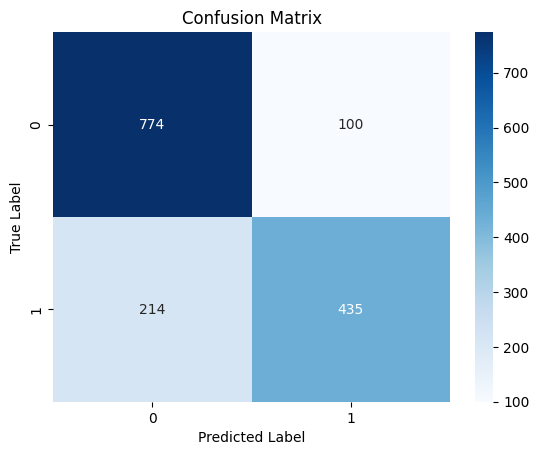

In [14]:
# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation Accuracy: {accuracy:.4f}')

# Generate a classification report
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)

# Visualizing the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [15]:
# Load the test set
test_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

# Preprocess the test data
test_df['cleaned_text'] = test_df['text'].apply(preprocess_text)

# Transform the test data using the TF-IDF vectorizer
X_test_tfidf = tfidf.transform(test_df['cleaned_text'])

# Predict on the test data
test_pred = model.predict(X_test_tfidf)

In [16]:
# Create a submission DataFrame
submission = pd.DataFrame({
    'id': test_df['id'],
    'target': test_pred
})

In [17]:
submission.to_csv('submission.csv', index=False)